# pyKROME Quick Start

Assumes `python3`
Requires `numpy`, `ctypes`, `matplotlib`.

In [1]:
%matplotlib widget

### First step: Run the KROME pre-processor with the `-interfacePy` option:

### If everything works, you should have a `libkrome.so` and `pykrome.py` files in your `build` folder.

We are packaging KROME into a shared library which can be called from another program (in this case, Python).

### - You have to point Python to the location where external modules can be found.

### - At the moment, this has to be done both at the system level, and also to pyKROME itself.

In [1]:
import sys
# set absolute path to `libkrome.so`
krome_lib_dir = "/home/jramsey/repos/krome/build"
# add to system PYTHONPATH
sys.path.append("/home/jramsey/repos/krome/build")

### Or `export PYTHONPATH=$PYTHONPATH:/home/jramsey/repos/krome/build` _before_ launching Python.

In [2]:
import numpy as np
from pykrome import PyKROME
import ctypes
import matplotlib.pyplot as plt

### The behind-the-scenes magic is that you make KROME speak "C" in order to be able to access it from Python.

_This isn't the only way to do it, but it is the simplest and most robust (that we've found)._

If you'd like to see how it works, `pykrome.py` in your `build` folder spells out the interfaces to each function or subroutine.
If you look at the KROME source files, e.g., `krome.f90`, there is now a `bind(C)` at the end of each function/subroutine declaration, and input/output arguments have had their types modified to by "C types".

For further information, see https://gcc.gnu.org/onlinedocs/gfortran/Interoperability-with-C.html

Let's take a look at the reaction network we're using:

Note the presence of `@common` tokens that lead to the creation of "user" subroutines.

## How to use KROME from Python

- ALL KROME functions are invoked using `pyk.lib.`

- KROME variables are accessed without `.lib` (e.g. `pyk.krome_idx_H`).

In [3]:
# Create a pyKROME object (NOTE )
pyk = PyKROME(path_to_lib=krome_lib_dir)
# Initialize KROME
pyk.lib.krome_init()

spy = pyk.krome_seconds_per_year

Initialize abundances, set user variables.

## Remember: Python is trying to talk "C" to KROME.

For scalar variables (non-arrays), you will need to:

1. Make sure you're passing the "ctype" of the variable
2. C passes arguments by value by default, so you need to explicitly pass it **by reference** to be able to get back any changes to the variable.
3. Since any returned value will have be a "ctype", one needs to then extract the value (again, only for non-array variables).

For arrays, these steps are not necessary (there is some behind the scenes pointer magic courtesy of `numpy.ctypeslib`.

In [4]:
x = np.ones(pyk.krome_nmols) * 1e-20
ntot = 1.0e4 # cm**-3
x[pyk.krome_idx_Hj] = ntot

# set iron abundance
pyk.lib.krome_scale_z(x, 0.0)
x[pyk.krome_idx_FEj] = x[pyk.krome_idx_FE]
x[pyk.krome_idx_FE] = 0.0
x[pyk.krome_idx_E] = pyk.lib.krome_get_electrons(x)

# ----==== Isotope decay on ====---- #
# set 60Fe abundance
pyk.lib.krome_set_user_tauh(1.5e6 * spy)
x_Fe60 = 1.0e-6
print('Fe-60 abundance =',x_Fe60)
x[pyk.krome_idx_60FE] = x_Fe60 * x[pyk.krome_idx_FEj]
# set rate for ionisation by isotope decay
fe60_xi = 1.0e-10
print('Isotope decay on.')
pyk.lib.krome_set_user_xi(fe60_xi)
# set heating from isotope decay
pyk.lib.krome_set_user_wergs(36.0 * pyk.krome_eV_to_erg)

# ***NB: in order to have the updated `Tgas` that KROME returns tracked, `Tgas`
# needs to be a ctype.
Tgas = ctypes.c_double(1.0e3)

# initializations
t = 0.0
dt = 1.0e-2 * spy
times = []
nstep = 0
output = []
save_Tgas = []
# loop over time
while t <= 1.0e8 * spy:
    dt = dt * 1.1
    t += dt
    times.append(t)
    if np.mod(nstep,10) == 0: print("nstep = {0:4d}, T_gas = {1:.3f}".format(nstep,Tgas.value))

    # call KROME
    # For scalar variables (non-arrays), you will need to:
    # a) make sure you're passing the "ctype" of the variable
    # b) C passes arguments by value by default, so you need to explicitly pass it
    #    *by reference* to be able to get back any changes to the variable.
    pyk.lib.krome(x, ctypes.byref(Tgas), ctypes.byref(ctypes.c_double(dt)))
    # c) Since any returned value will have be a "ctype", one needs to extract the value.
    save_Tgas.append(Tgas.value)

    nstep += 1

    # save results
    output.append(np.concatenate((np.array([t/spy, Tgas.value]), x/ntot)))

    # dump populations of atomic levels (for cooling rates)
    # "72" is the unit number to be used by Fortran.
    #pyk.lib.krome_popcool_dump(t/spy, 72)

# convert output lists to numpy arrays
output = np.array(output)
times = np.array(times)
save_Tgas = np.array(save_Tgas)

print("Finished. Number of steps = {}".format(nstep))

Fe-60 abundance = 1e-06
Isotope decay on.
nstep =    0, T_gas = 1000.000
nstep =   10, T_gas = 979.963
nstep =   20, T_gas = 933.329
nstep =   30, T_gas = 839.836
nstep =   40, T_gas = 701.590
nstep =   50, T_gas = 572.544
nstep =   60, T_gas = 497.077
nstep =   70, T_gas = 463.343
nstep =   80, T_gas = 448.913
nstep =   90, T_gas = 442.212
nstep =  100, T_gas = 438.635
nstep =  110, T_gas = 436.582
nstep =  120, T_gas = 435.968
nstep =  130, T_gas = 438.221
nstep =  140, T_gas = 447.808
nstep =  150, T_gas = 475.749
nstep =  160, T_gas = 543.698
nstep =  170, T_gas = 683.623
nstep =  180, T_gas = 886.186
nstep =  190, T_gas = 1014.757
nstep =  200, T_gas = 1029.228
nstep =  210, T_gas = 1029.266
Finished. Number of steps = 217


### NOTE: **Not all** KROME functions/subroutines work from Python.

In particular, Fortran character arrays/strings do not play nice with Python/C!

One can access many attributes/properties of your KROME set up (plus a few convenient constants):

In [5]:
pyk.krome_nmols

7

In [6]:
pyk.krome_names

('E', 'H', 'FE', '[60FE]', '[60NI]', 'H+', 'FE+', 'CR', 'g', 'Tgas', 'dummy')

In [7]:
pyk.krome_idx_H

1

In [8]:
pyk.krome_p_mass # in g

1.67262158e-24

### Now, let's plot the results.

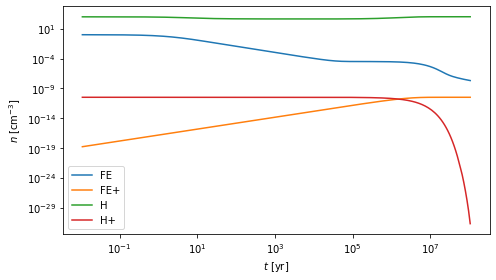

In [9]:
fig1 = plt.figure(figsize=(7.0,4.0))
fig1.clf()
ax = fig1.add_subplot(1,1,1)

for i in [2,6,1,5]:
    ax.loglog(times/spy,output[:,i],label=pyk.krome_names[i])

ax.set_xlabel(r"$t$ [yr]")
ax.set_ylabel(r"$n$ [cm$^{-3}$]")
ax.legend(loc='lower left')

fig1.tight_layout()

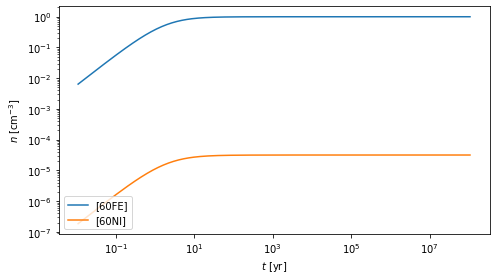

In [10]:
fig2 = plt.figure(figsize=(7.0,4.0))
fig2.clf()
bx = fig2.add_subplot(1,1,1)

for i in [3,4]:
    bx.loglog(times/spy,output[:,i],label=pyk.krome_names[i])

bx.set_xlabel(r"$t$ [yr]")
bx.set_ylabel(r"$n$ [cm$^{-3}$]")
bx.legend(loc='lower left')

fig2.tight_layout()

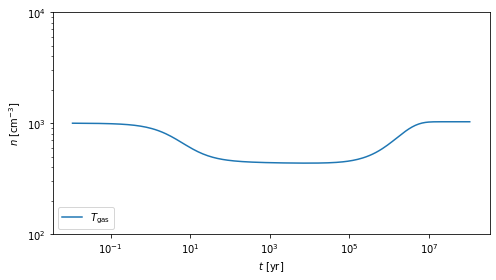

In [11]:
fig3 = plt.figure(figsize=(7.0,4.0))
fig3.clf()
cx = fig3.add_subplot(1,1,1)

cx.loglog(times/spy,save_Tgas,label=r"$T_{\rm gas}$")

cx.set_xlabel(r"$t$ [yr]")
cx.set_ylabel(r"$n$ [cm$^{-3}$]")
cx.axis(ymin=1.0e2,ymax=1.0e4)
cx.legend(loc='lower left')

fig3.tight_layout()

## Examples of invoking KROME **in parallel** from Python

### NB!: These are **not** minimum working examples (MWEs)! Only code snippets!

- Python runs things in parallel by launching individual processes. And we need to initialize KROME for _each_ process.

### 1. Snippet using `joblib`

- Example of iterating over a list (or parameter space) of densities and temperatures.

In [ ]:
from pykrome import PyKROME

def set_initial_abundances(pyk, ngas):
    """Initialize species abundances."""
   
    # default initialization for all species; see below.
    abundances = np.ones(pyk.krome_nmols) * 1e-20
    
    pyk.lib.krome_scale_z(abundances,0.0)
    # initial abundances taken from Bruderer et al. (2009, ApJS, 183, 179; App. C)
    # which species to include will depend on your network!!
    abundances[pyk.krome_idx_H2]  = ntot * 0.5
    abundances[pyk.krome_idx_H]   = ntot * 5.0e-8
    abundances[pyk.krome_idx_Hj]  = ntot * 3.0e-10
    abundances[pyk.krome_idx_H3j] = ntot * 2.0e-9
    abundances[pyk.krome_idx_HE]  = ntot * 8.5e-2
    abundances[pyk.krome_idx_HEj] = ntot * 2.0e-10
    abundances[pyk.krome_idx_C]   = ntot * 3.5e-4
    abundances[pyk.krome_idx_N]   = ntot * 1.0e-4
    abundances[pyk.krome_idx_N2]  = ntot * 3.5e-5
    abundances[pyk.krome_idx_O]   = ntot * 4.0e-5
    abundances[pyk.krome_idx_CO]  = ntot * 1.8e-4
    abundances[pyk.krome_idx_CO2] = ntot * 1.5e-5
    abundances[pyk.krome_idx_H2O] = ntot * 7.5e-5
    abundances[pyk.krome_idx_HCOj] = ntot * 3.0e-9
    abundances[pyk.krome_idx_H2CO] = ntot * 6.0e-8
    abundances[pyk.krome_idx_CH4]  = ntot * 5.0e-8
    abundances[pyk.krome_idx_CH3OH] = ntot * 5.0e-7
    # set free electron abundance based on the other abundances
    abundances[pyk.krome_idx_E] = pyk.lib.krome_get_electrons(abundances)

    return abundances

def chemistry(i, rhogas, temperature, tlimit, mu=2.34, loud=True):
    """Prepare model for KROME calculations."""

    # initialize KROME
    pyk = pykrome.PyKROME(path_to_lib=krome_lib_dir)
    pyk.lib.krome_init()

    spy = pyk.krome_seconds_per_year

    # convert from mass density to number density
    ntot = rhotot / (mu * pyk.krome_p_mass)

    abundances = set_initial_abundances(pyk, ntot)

    # set cosmic-ray ionization rate (constant in space and time)
    pyk.lib.krome_set_user_crate(5.0e-17)

    # convert temperature to ctype
    temp_gas = ctypes.c_double(temperature)

    # initializations
    time = 0.0
    delta_t = 1.0e3 * spy
    nstep = 0
    ierr = ctypes.c_int(0)

    # do loop over time
    while time < tlimit * spy:
        pyk.lib.krome(abundances, ctypes.byref(temp_gas),
                      ctypes.byref(ctypes.c_double(delta_t)),ctypes.byref(ierr))

        # `ierr` is not exposed to the user by default, need to include `-useIERR` when calling the KROME pre-processor
        if ierr.value != 0:
            print "WARNING: There was a problem with KROME (ierr = {0}).".format(ierr.value)
            print "t =", time/spy, "yr; i =", i,"; nstep =", nstep
            print "ngas =", ntot," ; Tgas =", temp_gas.value
        else:
            time += delta_t
            delta_t = delta_t * 1.1
            nstep += 1

    if loud: print "KROME: t =", time/spy, "yr; i = {:6d}".format(i),"; nstep =", nstep, "ngas =", ntot," ; Tgas =", temp_gas.value

    # done! returned updated abundances
    return abundances

In [ ]:
from joblib import Parallel, delayed

chemistry_time_limit = 1.0e6 * pyk.krome_seconds_per_year # 1 Myr
mu = 2.34
gas_density = np.logspace(...)
gas_temperature = np.logspace(...)

# 
data = Parallel(n_jobs=num_cores)(delayed(run_chemistry)
                                          (i,
                                           gas_density[i],
                                           gas_temperature[i],
                                           chemistry_time_limit,
                                           mu = mean_molecular_weight
                                           loud=loud)
                                           for i in cells)


### 2. Using `mpi4py`

- Example of post-processing of a big complicated simulation snapshot with KROME.

In [ ]:
def run_chemistry_single(pyk, initial_time_step, end_time, Tgas, x, verbose=1, alpha=1.0):
    """
    Run KROME (0-D) for several time steps on a *single* point and save the output after each step.

    `alpha` is the multiplicative factor applied to the time step after every step (default = 1.0).

    """

    dt = initial_time_step * pyk.krome_seconds_per_year
    t = 0.0
    nstep = 0
    xsave, tsave, Tgsave = [], [], []
    ierr = ctypes.c_int(0)
    Tgl = ctypes.c_double(Tgas)

    while t < end_time * pyk.krome_seconds_per_year:
        if t == 0.0: dtstart = dt
        dtl = ctypes.c_double(dt)
        x[pyk.krome_idx_E] = pyk.lib.krome_get_electrons(x[:]) # reset the electron abundance
        xprev = x.copy()
        pyk.lib.krome(x, ctypes.byref(Tgl), dtl, ctypes.byref(ierr))
        t += dt
        dtold = dt
        dt *= alpha
        nstep += 1
        if verbose > 1: print("nstep = {0:3d}; time = {1:5.2e} yr; dt = {2:5.2e} yr; ierr = {3:2d}; Tgas = {4:8.4e} K".format(nstep,t/pyk.krome_seconds_per_year,dtold/pyk.krome_seconds_per_year,ierr.value,Tgl.value))
        # did KROME converge?
        if ierr.value != 0:
            print("WARNING: There was a problem with KROME (ierr = {0}).".format(ierr.value))
            print(Tgl.value, dt, t, nstep)

        tsave.append(t)
        Tgsave.append(Tgl.value)
        xsave = np.array(x[:])

    if verbose > 1: print("Chemistry run finished. No. calls to KROME: {0}".format(nstep))

    return xsave, tsave, Tgsave, ierr.value

In [ ]:
def run_chemistry_batch(indices, initial_time_step, end_time, pyk, ngas, Tgas, xold, rank, size, verbose=1):
    """Invoke KROME on a list of cells/points."""

    alpha = 1.1
    Tgnew = np.ones_like(Tgas) * -1.0
    xnewpp = []

    nstep = 0
    numsteps = len(indices)
    print("r {0:3d}: numsteps = {1}".format(rank,numsteps))
    ierr = 0
    tall = None
    for i,j,k in indices:
        tstart = timer()
        xold[:,:,:,:] = 1e-30
        xold[:,i,j,k] = set_initial_abundances(pyk,ngas)
        xsave = xold.copy().squeeze()
        xl = np.ascontiguousarray(xold[:].squeeze())

        xnew, tall, Tgall, ierr = run_chemistry_single(pyk, initial_time_step, end_time, Tgas[i,j,k], xl,
                                                       verbose=verbose, alpha=alpha)

        # did KROME converge?
        if ierr != 0:
            print("==> KROME did not converge!", rank, i, j, k, nstep, "<==")
            print(Tgall, Tgas[i,j,k])
            print(ngas[i,j,k])
            xnew[:] = np.nan
            Tgnew[i,j,k] = Tgas[i,j,k]
            nstep += 1
            continue

        tend = timer()
        elapsed = tend - tstart

        Tgnew[i,j,k] = Tgall[len(Tgall)-1]
        print("r {0:3d}: nstep = {1}; i = {2}, j = {3}, k = {4}; ngas = {5}; Tgas = {6}; {7:0.2f} mins.".format(rank,nstep,i,j,k,ngas[i,j,k],Tgas[i,j,k],elapsed/60.0))
        xnewpp.append(xnew)
        nstep += 1

    if nstep == 0: print("Warning: r {0:d}; no calculations performed!".format(rank))

    return xnewpp, tall, Tgnew, nstep, ierr

In [ ]:
from mpi4py import MPI

# start up MPI
mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()
mpi_master = 0

chunk_size = 1
mu = 2.34
initial_time_step = 1.0e2 # in years
end_time = 1.0e6 # in years

if mpi_rank == mpi_master:
    print "No. ranks:", mpi_size

# initialise local instance of KROME
pyk = PyKROME(path_to_lib=krome_lib_dir)

pyk.lib.krome_init() # initialise KROME

pyk.lib.krome_set_user_crate(1.3e-17) # set (constant) cosmic ray flux

# read big model (density, temperature, etc.)
x, y, z, q = read_snapshot(...)
nx1 = x.shape[0]
nx2 = y.shape[0]
nx3 = z.shape[0]
rho = q['d'] # gas mass density
Tgas = q['T'] # gas temperature
# convert to number density
ngas = rho / (mu * pyk.krome_p_mass)

# set up run
if mpi_rank == mpi_manager:
    print('No. of species: ', pyk.krome_nmols)
    print('No. of reactions: ', pyk.krome_nrea)
    print('rho min., max.: ', rho.min(), rho.max(), rho.shape)
    print('ngas min., max.: ', ngas.min(), ngas.max(), ngas.shape)
    print('Tgas min., max.: ', Tgas.min(), Tgas.max(), Tgas.shape)
    print("MPI chunk size: {0:d}".format(ichunk))
    print("Total number of cells: {0:d}x{1:d}x{2:d} = {3:d}".format(nx1, nx2, nx3, nx1*nx2*nx3))
    
    # create list of indices where chemistry should be solved
    indices = [(i,j,k) for k in range(nx3) for j in range(nx2) for i in range(nx1)]
    indices_pp = np.array_split(indices, len(indices)/ichunk)
    ifilled = 0
    # initialize abundances array
    x = np.ones([pyk.krome_nmols,nx1,nx2,nx3],order='F')*-1.0
    
    print("Memory used for 'x': {0:8.3f} MB".format(x.size * x[0,0,0,0].nbytes / 1024.0**2))
    print("="*40)

mpi_comm.barrier()
# do real work!
if mpi_rank == mpi_manager:
    # ----====<<<< MANAGER REGION >>>>====----
    oranks = [i for i in range(mpi_size)]
    oranks.remove(0) # the manager does not do any real work ;P
    ranks = []
    info = MPI.Status()

    # initial work distribution
    for r in oranks:
        if len(indices_pp)>0:
            cindices = indices_pp.pop(0)
            mpi_comm.send(cindices,dest=r) # send work
            print(">>> Sending work to r{}...".format(r))
        else:
            print("No work for you! r{}".format(r))
            mpi_comm.send((-1,-1),dest=r)
            oranks.remove(r)
            ranks.append(r)

    while len(oranks)>0:
        data = mpi_comm.recv() # receive completed work
        orank = data[0]
        findices = data[1]
        xnewpp = data[2]
        print(">>> Rank {} data received".format(orank))
        # put abundances into manager array
        for ijk,xpp in zip(findices,xnewpp):
            i, j, k = ijk
            x[:,i,j,k] = xpp[:]
            ifilled += 1
        progress = np.float(ifilled)/np.float(total_nsteps)
        print(">>> Progress: {0:0.3f}%".format(100.0*progress))

        # distribute more work
        if len(indices_pp)>0:
            cindices = indices_pp.pop(0)
            mpi_comm.send(cindices,dest=data[0]) # send work
        else:
            print("No more work for you! r{}".format(orank))
            mpi_comm.send((-1,-1,-1),dest=orank) # send "-1" as finalization "message"
            oranks.remove(orank)
            ranks.append(orank)

else:
    # ----====<<<< WORKER REGION >>>>====----
    cindices = mpi_comm.recv(source=mpi_manager) # here's some initial work from the manager
    while True:
        print("r{}: I'm working!".format(mpi_rank))
        x = np.empty([pyk.krome_nmols,1,1,1])
        xpp, times, Tgnew, nstep, ierr = run_chemistry_batch(cindices, initial_time_step, end_time, pyk, ngas,
                                            Tgas, x, mpi_rank, mpi_size)

        mpi_comm.send([mpi_rank,cindices,xpp],dest=mpi_manager) # return finished work
        print("<<< r{}: Completed work sent to manager.".format(mpi_rank))

        cindices = mpi_comm.recv(source=mpi_manager) # I need more work

        if (np.array(cindices) == (-1,-1,-1)).all():
            print("r{}: No more work for me!".format(mpi_rank))
            break

print("==> Rank {} finished".format(mpi_rank))
mpi_comm.barrier()
if mpi_rank == mpi_manager:
    if mpi_size > 1:
        print("All ranks finished.")
        outfile = 'savex_i{0:d}_n{1:d}_{2}.npz'.format(istep,mpi_size,out_tag)
        print("Saving results to {0}...".format(outfile))
        np.savez(outfile, indices=indices, x=x)
    else:
        print("Only one rank.")


After much experimentation, I found that the most efficient way is to give out a single cell/point of work at a time to each MPI rank; some cells will take much longer than others, so this approach helps efficiency. Your mileage may vary depending on your problem and the computers you're using.

### Remember: These are snippets, not working examples!!